# Import Necessary Libraries

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, ElasticNet, BayesianRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings("ignore")

# Import Dataset

In [57]:
df = pd.read_csv('qsar_fish_toxicity.csv',header = None, delimiter = ';')
df.head()

,0,1,2,3,4,5,6
0,3.260,0.829,1.676,0,1,1.453,3.770
1,2.189,0.580,0.863,0,0,1.348,3.115
2,2.125,0.638,0.831,0,0,1.348,3.531
3,3.027,0.331,1.472,1,0,1.807,3.510
4,2.094,0.827,0.860,0,0,1.886,5.390


In [58]:
df.rename({0: 'CIC0', 1: 'SM1_Dz', 2: 'GATS1i', 3: 'NdsCH', 4: 'NdssC', 5: 'MLOGP', 6: 'quantitative response, LC50 [-LOG(mol/L)]'},axis = 1, inplace = True)
df.head()

,CIC0,SM1_Dz,GATS1i,NdsCH,NdssC,MLOGP,"quantitative response, LC50 [-LOG(mol/L)]"
0,3.260,0.829,1.676,0,1,1.453,3.770
1,2.189,0.580,0.863,0,0,1.348,3.115
2,2.125,0.638,0.831,0,0,1.348,3.531
3,3.027,0.331,1.472,1,0,1.807,3.510
4,2.094,0.827,0.860,0,0,1.886,5.390


In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 908 entries, 0 to 907
Data columns (total 7 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   CIC0                                       908 non-null    float64
 1   SM1_Dz                                     908 non-null    float64
 2   GATS1i                                     908 non-null    float64
 3   NdsCH                                      908 non-null    int64  
 4   NdssC                                      908 non-null    int64  
 5   MLOGP                                      908 non-null    float64
 6   quantitative response, LC50 [-LOG(mol/L)]  908 non-null    float64
dtypes: float64(5), int64(2)
memory usage: 49.8 KB


In [60]:
df.describe()

,CIC0,SM1_Dz,GATS1i,NdsCH,NdssC,MLOGP,"quantitative response, LC50 [-LOG(mol/L)]"
count,908.000000,908.000000,908.000000,908.000000,908.000000,908.000000,908.000000
mean,2.898129,0.628468,1.293591,0.229075,0.485683,2.109285,4.064431
std,0.756088,0.428459,0.394303,0.605335,0.861279,1.433181,1.455698
min,0.667000,0.000000,0.396000,0.000000,0.000000,-2.884000,0.053000
25%,2.347000,0.223000,0.950750,0.000000,0.000000,1.209000,3.151750
50%,2.934000,0.570000,1.240500,0.000000,0.000000,2.127000,3.987500
75%,3.407000,0.892750,1.562250,0.000000,1.000000,3.105000,4.907500
max,5.926000,2.171000,2.920000,4.000000,6.000000,6.515000,9.612000


# Check for missing values

In [61]:
df.isna().sum()

CIC0                                         0
SM1_Dz                                       0
GATS1i                                       0
NdsCH                                        0
NdssC                                        0
MLOGP                                        0
quantitative response, LC50 [-LOG(mol/L)]    0
dtype: int64

# Plotting Correlation

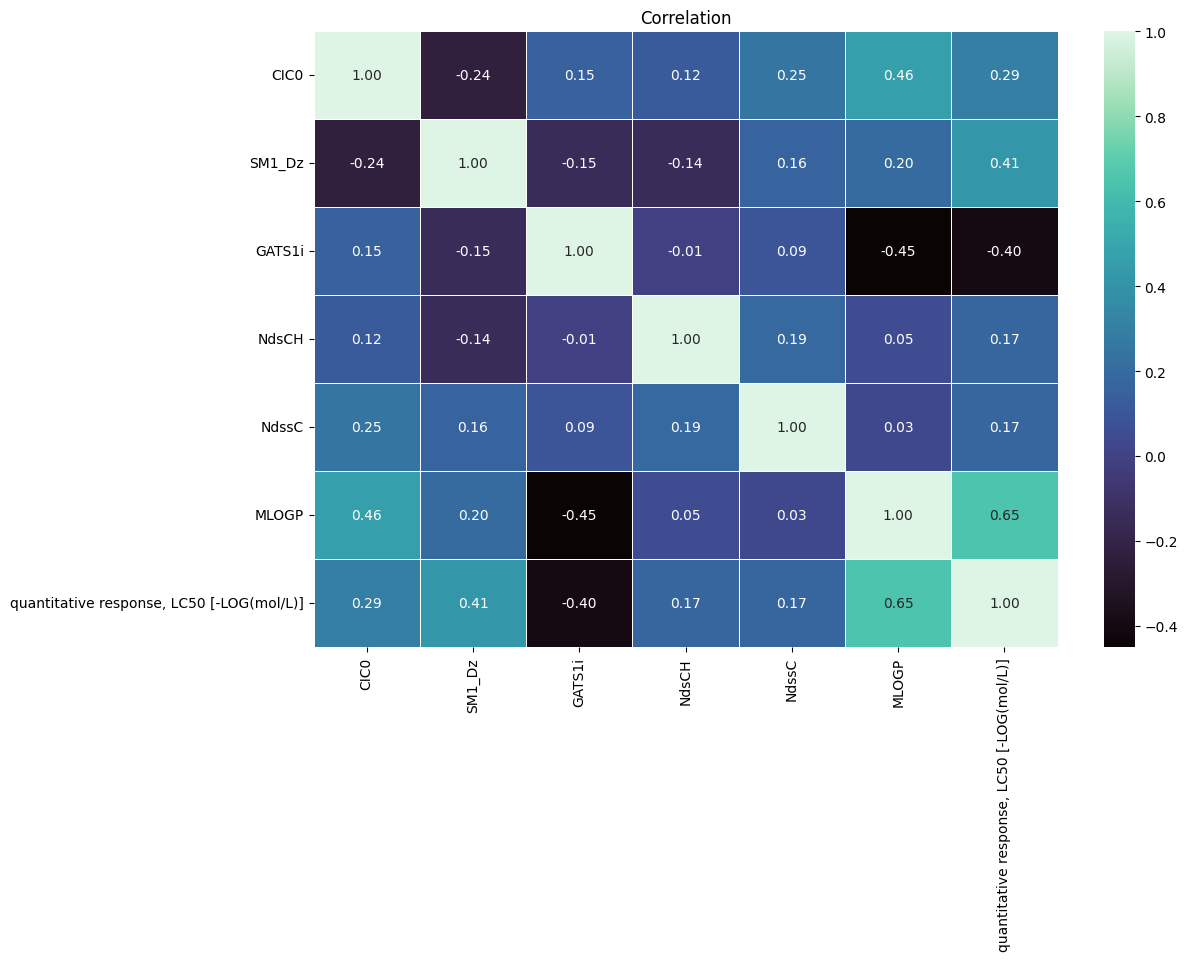

In [62]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), annot = True, cmap='mako', fmt='.2f', linewidth=.5)
plt.title('Correlation')
plt.show()

array([[<Axes: title={'center': 'CIC0'}>,
        <Axes: title={'center': 'SM1_Dz'}>,
        <Axes: title={'center': 'GATS1i'}>],
       [<Axes: title={'center': 'NdsCH'}>,
        <Axes: title={'center': 'NdssC'}>,
        <Axes: title={'center': 'MLOGP'}>],
       [<Axes: title={'center': 'quantitative response, LC50 [-LOG(mol/L)]'}>,
        <Axes: >, <Axes: >]], dtype=object)

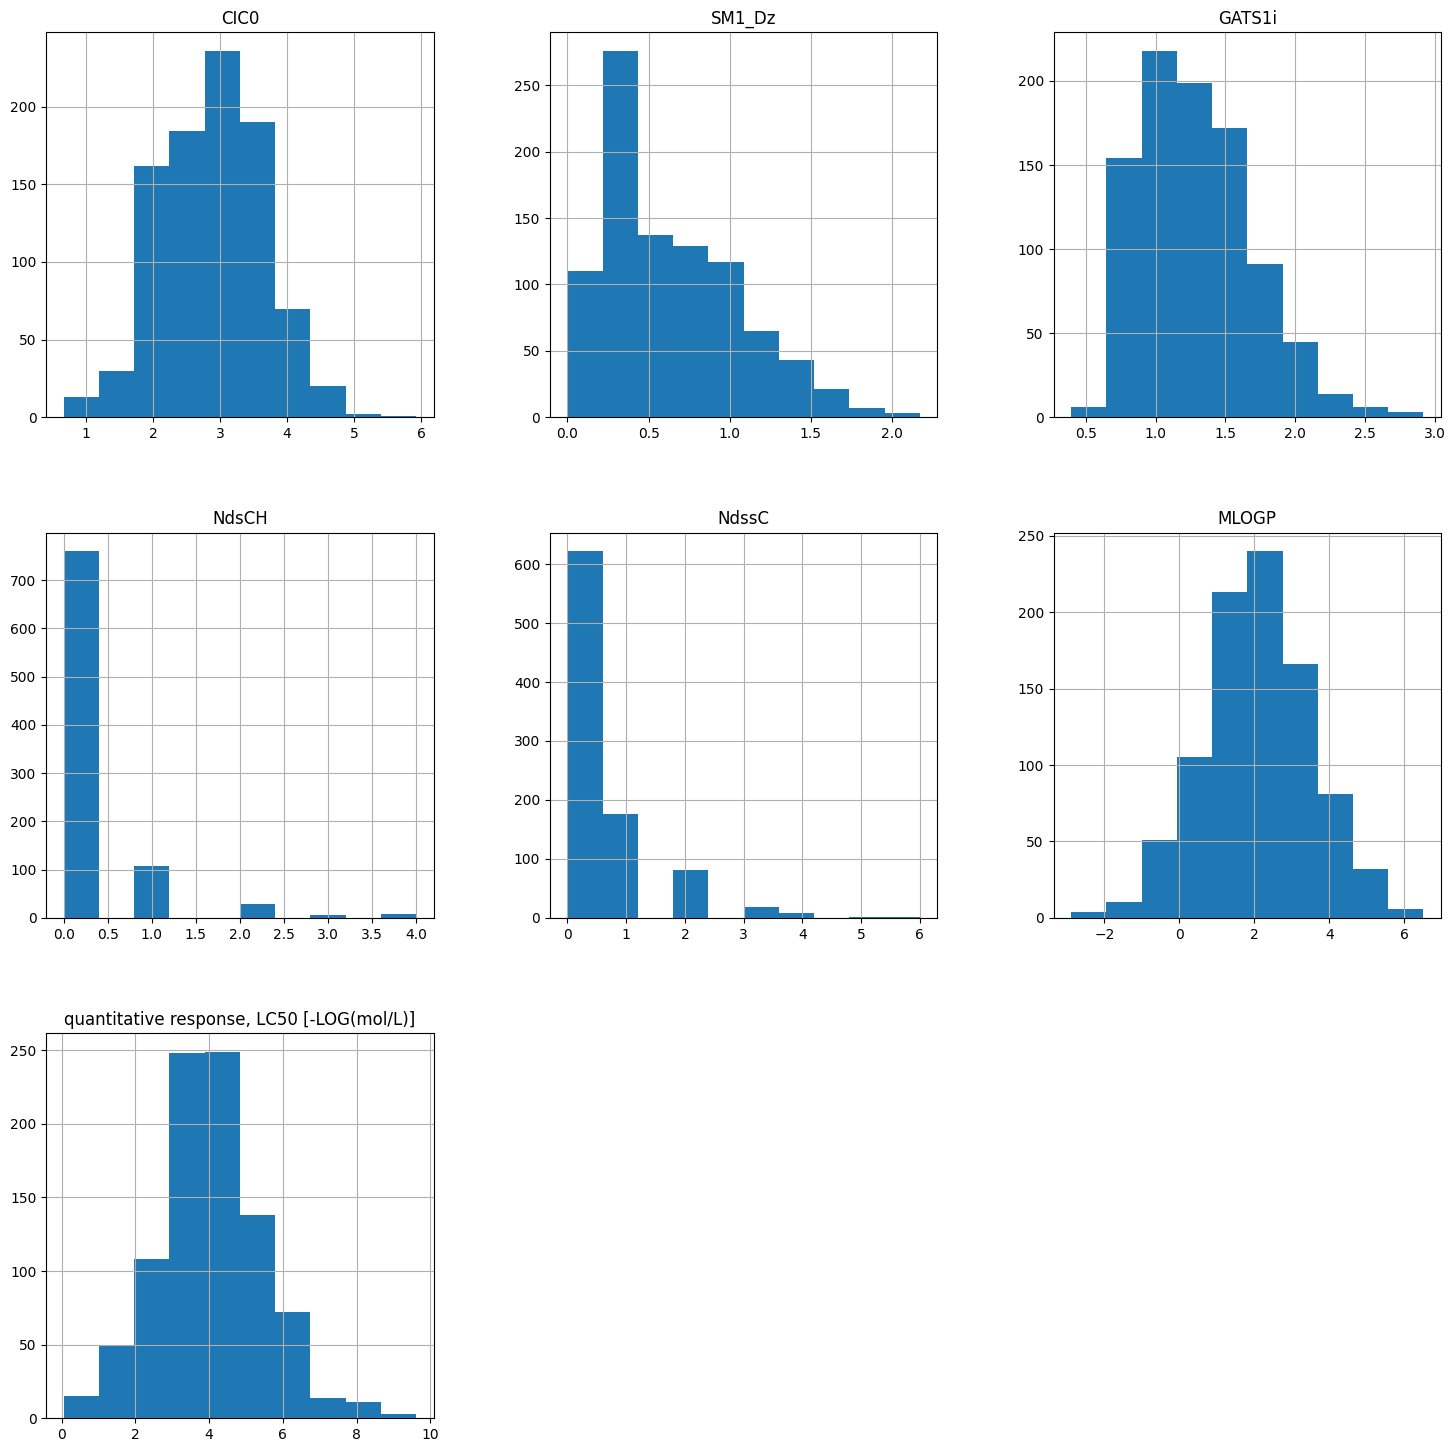

In [63]:
df.hist(figsize=(18,18), layout=(3,3))

In [64]:
# We have two categorical variables in the dataset
unique_NdsCH = df['NdsCH'].unique()
unique_NdssC = df['NdssC'].unique()

print(unique_NdsCH)
print(unique_NdssC)

[0 1 3 2 4]
[1 0 3 2 4 5 6]


# Checking for outliers

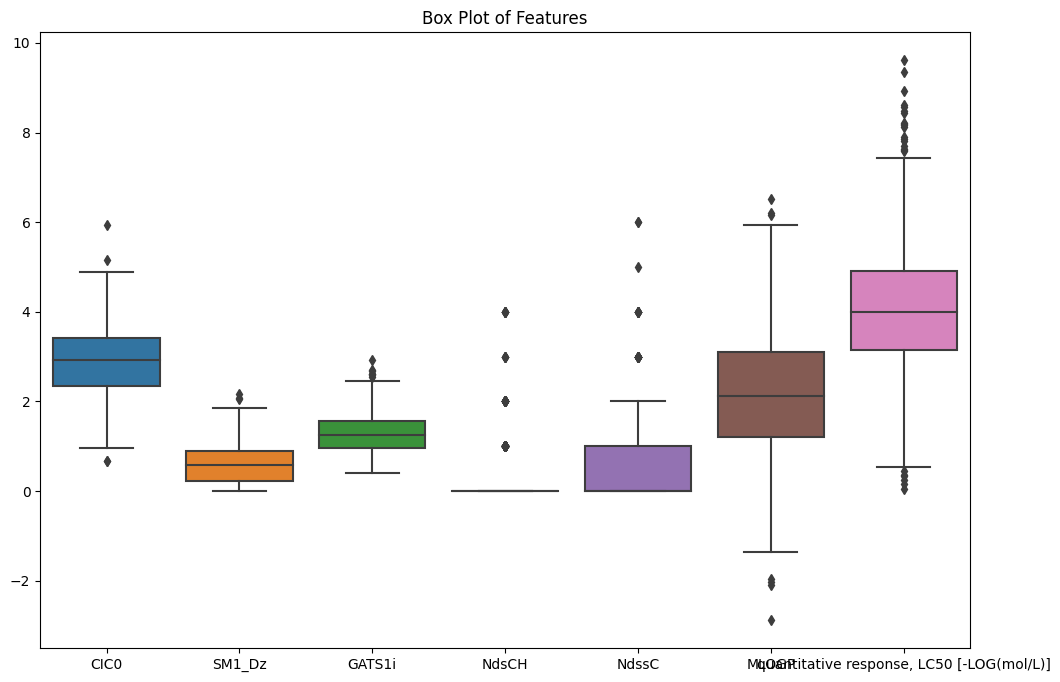

In [65]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=df)
plt.title("Box Plot of Features")
plt.show()

In [66]:
feature_name = 'CIC0'

Q1 = df[feature_name].quantile(0.25)
Q3 = df[feature_name].quantile(0.75)
IQR = Q3 - Q1

In [67]:
df.drop(df[(df[feature_name] < (Q1 - 1.5 * IQR)) | (df[feature_name] > (Q3 + 1.5 * IQR))].index, inplace=True)

# Distribution of Categorical variables

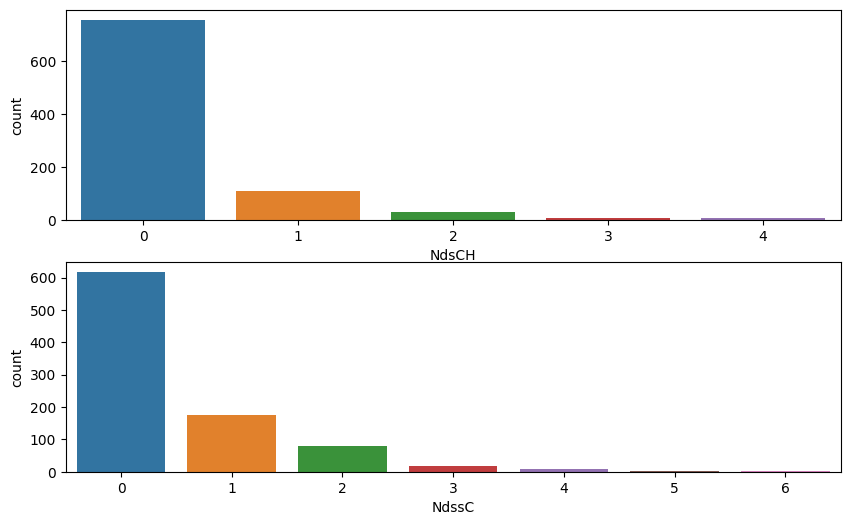

NdsCH distribution:
0    756
1    107
2     29
4      7
3      5
Name: NdsCH, dtype: int64

NdssC distribution:
0    618
1    176
2     81
3     18
4      8
6      2
5      1
Name: NdssC, dtype: int64


In [68]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
sns.countplot(x='NdsCH', data=df)

plt.subplot(2, 1, 2)
sns.countplot(x='NdssC', data=df)

plt.show()

print("NdsCH distribution:")
print(df['NdsCH'].value_counts())

print("\nNdssC distribution:")
print(df['NdssC'].value_counts())

In [69]:
df.shape

(904, 7)

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 904 entries, 0 to 907
Data columns (total 7 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   CIC0                                       904 non-null    float64
 1   SM1_Dz                                     904 non-null    float64
 2   GATS1i                                     904 non-null    float64
 3   NdsCH                                      904 non-null    int64  
 4   NdssC                                      904 non-null    int64  
 5   MLOGP                                      904 non-null    float64
 6   quantitative response, LC50 [-LOG(mol/L)]  904 non-null    float64
dtypes: float64(5), int64(2)
memory usage: 56.5 KB


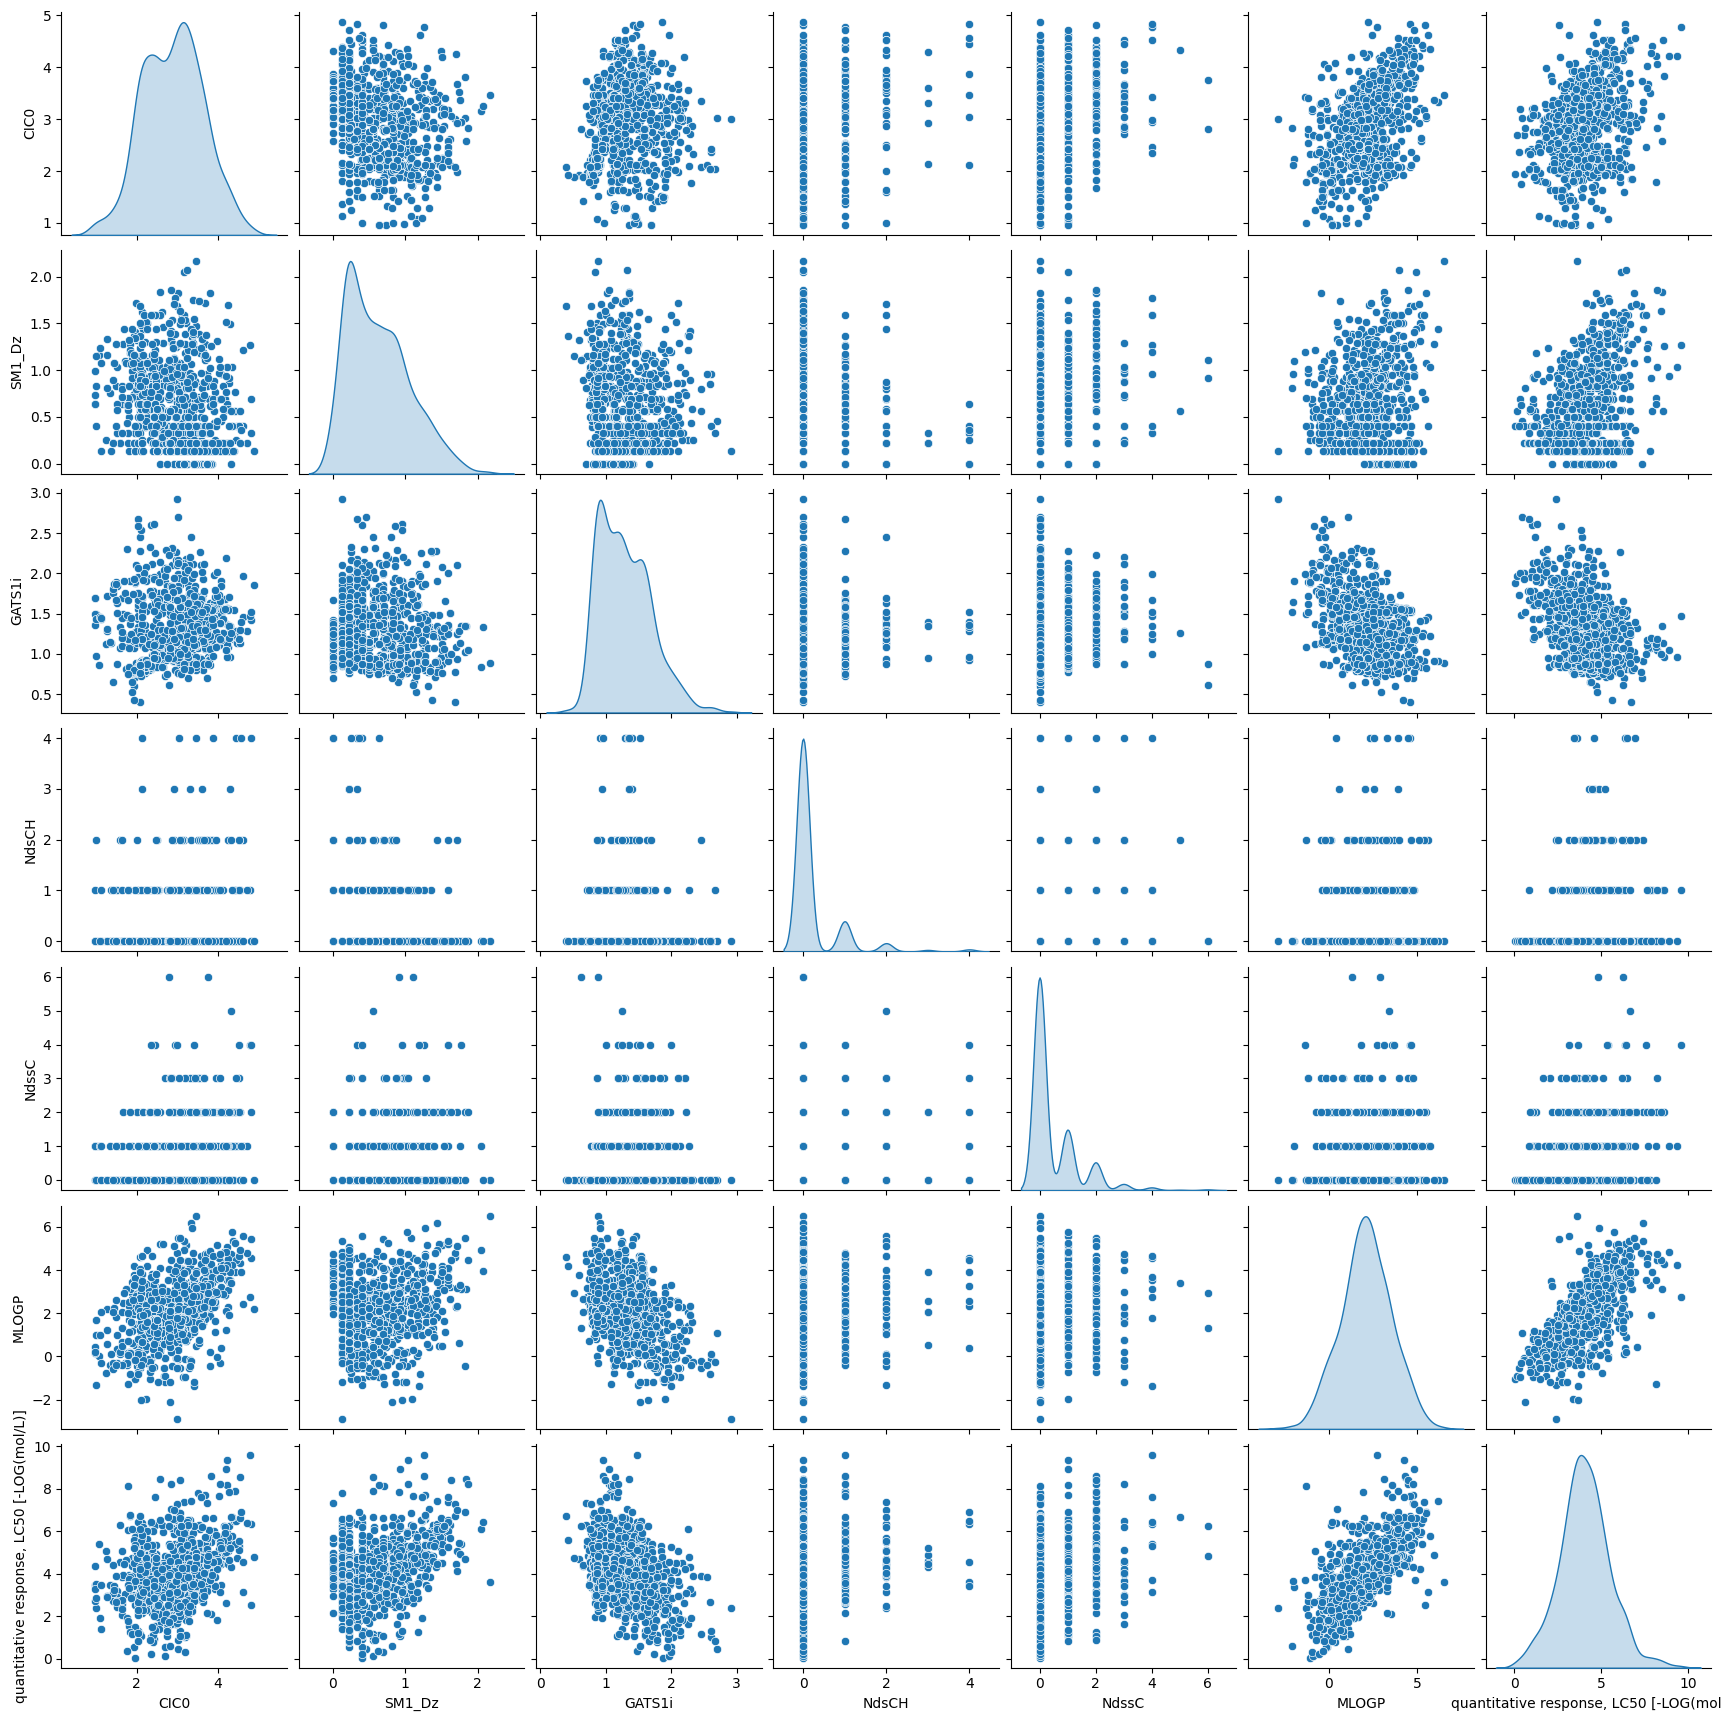

In [71]:
sns.pairplot(data=df, diag_kind='kde')

In [72]:
categorical_columns = ['NdsCH', 'NdssC']
data_encoded = pd.get_dummies(df, columns=categorical_columns)

X = data_encoded.drop(['quantitative response, LC50 [-LOG(mol/L)]'],axis = 1)
Y = data_encoded[['quantitative response, LC50 [-LOG(mol/L)]']]

In [73]:
data_encoded

,CIC0,SM1_Dz,GATS1i,MLOGP,"quantitative response, LC50 [-LOG(mol/L)]",NdsCH_0,NdsCH_1,NdsCH_2,NdsCH_3,NdsCH_4,NdssC_0,NdssC_1,NdssC_2,NdssC_3,NdssC_4,NdssC_5,NdssC_6
0,3.260,0.829,1.676,1.453,3.770,1,0,0,0,0,0,1,0,0,0,0,0
1,2.189,0.580,0.863,1.348,3.115,1,0,0,0,0,1,0,0,0,0,0,0
2,2.125,0.638,0.831,1.348,3.531,1,0,0,0,0,1,0,0,0,0,0,0
3,3.027,0.331,1.472,1.807,3.510,0,1,0,0,0,1,0,0,0,0,0,0
4,2.094,0.827,0.860,1.886,5.390,1,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
903,2.801,0.728,2.226,0.736,3.109,1,0,0,0,0,0,0,1,0,0,0,0
904,3.652,0.872,0.867,3.983,4.040,0,0,1,0,0,0,0,0,1,0,0,0
905,3.763,0.916,0.878,2.918,4.818,1,0,0,0,0,0,0,0,0,0,0,1
906,2.831,1.393,1.077,0.906,5.317,1,0,0,0,0,0,1,0,0,0,0,0


In [75]:
sc = StandardScaler()
X_scaled = sc.fit_transform(X)

# Train Test Split

In [23]:
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size = 0.25, random_state = 50)


# Linear Regression

Linear regression is a statistical method that models the relationship between a dependent variable and one or more independent variables by fitting a linear equation to the observed data. The goal is to find the best-fit line that minimizes the sum of squared differences between predicted and actual values. This technique is widely used for predicting numerical outcomes based on input features in various fields.

In [76]:
lr = LinearRegression()
lr.fit(X_train, Y_train)

print('Training Score : ', lr.score(X_train,Y_train))

lr_pred = lr.predict(X_test)

#Calculate R2 Score
lr_score = r2_score(Y_test, lr_pred)

#Calculate MSE
lr_mse = mean_squared_error(Y_test, lr_pred)

#Calculate RMSE
lr_rmse = np.sqrt(lr_mse)

#Calculate MAE
lr_mae = mean_absolute_error(Y_test, lr_pred)

print(f'R2 Score: {lr_score:.3f}' )
print(f'Mean Absolute Error: {lr_mae:.3f}' )
print(f'Mean Squared Error: {lr_mse:.3f}' )
print(f'Root Mean Squared Error: {lr_rmse:.3f}' )

Training Score :  0.5792672746118082
R2 Score: 0.625
Mean Absolute Error: 0.683
Mean Squared Error: 0.812
Root Mean Squared Error: 0.901


# Decison Tree Regressor

Decision Tree Regressor is a machine learning algorithm that models a predictive relationship between input features and a continuous target variable. It constructs a tree-like structure where each internal node represents a decision based on a specific feature, and each leaf node provides the predicted output. The algorithm recursively splits the dataset based on the feature that maximizes the reduction in variance, aiming to minimize the mean squared error of the predictions. Decision Tree Regressor is versatile and interpretable, making it suitable for tasks such as predicting numerical values in regression problems.

In [77]:
dt = DecisionTreeRegressor(max_depth = 20, min_samples_split = 20, min_samples_leaf = 20)
dt.fit(X_train, Y_train)

print('Training Score : ', dt.score(X_train,Y_train))

dt_pred = dt.predict(X_test)

#Calculate R2 Score
dt_score = r2_score(Y_test, dt_pred)

#Calculate MSE
dt_mse = mean_squared_error(Y_test, dt_pred)

#Calculate RMSE
dt_rmse = np.sqrt(dt_mse)

#Calculate MAE
dt_mae = mean_absolute_error(Y_test, dt_pred)

print(f'R2 Score: {dt_score:.3f}' )
print(f'Mean Absolute Error: {dt_mae:.3f}' )
print(f'Mean Squared Error: {dt_mse:.3f}' )
print(f'Root Mean Squared Error: {dt_rmse:.3f}' )

Training Score :  0.6343464536842202
R2 Score: 0.622
Mean Absolute Error: 0.680
Mean Squared Error: 0.819
Root Mean Squared Error: 0.905


# Random Forest Regressor
Random Forest Regressor is an ensemble learning algorithm that builds multiple decision trees and combines their predictions to achieve a more accurate and robust model for regression tasks. Each tree in the forest is trained on a subset of the data and makes independent predictions. The final prediction is typically the average (for regression) of the predictions from all the individual trees. Random Forest Regressor provides improved generalization, reduced overfitting, and increased model stability compared to a single decision tree. It is widely used for predicting continuous outcomes in various domains due to its flexibility and ability to capture complex relationships in the data.

In [78]:
model_rf= RandomForestRegressor()


In [294]:
param={'n_estimators': [500],
       'max_depth': [2,4,6,8,10,12,36],
        'max_features': ['auto', 'sqrt'],
        'min_samples_split': [2, 4,6,8,10]
      }

In [295]:
from sklearn.model_selection import RandomizedSearchCV
rand_rf= RandomizedSearchCV(model_rf,param, n_iter=20, verbose=3, n_jobs=-1, cv=10)

In [296]:
rand_rf.fit(X_train, Y_train)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


RandomizedSearchCV(cv=10, estimator=RandomForestRegressor(), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'max_depth': [2, 4, 6, 8, 10, 12, 36],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_split': [2, 4, 6, 8, 10],
                                        'n_estimators': [500]},
                   verbose=3)

In [297]:
rand_rf.best_params_

{'n_estimators': 500,
 'min_samples_split': 6,
 'max_features': 'sqrt',
 'max_depth': 36}

In [79]:
rf = RandomForestRegressor(n_estimators = 500, min_samples_split = 6, max_depth = 36, random_state = 42, max_features = 'sqrt')
rf.fit(X_train, Y_train)

print('Training Score : ', rf.score(X_train,Y_train))

rf_pred = rf.predict(X_test)

#Calculate R2 Score
rf_score = r2_score(Y_test, rf_pred)

#Calculate MSE
rf_mse = mean_squared_error(Y_test, rf_pred)

#Calculate RMSE
rf_rmse = np.sqrt(rf_mse)

#Calculate MAE
rf_mae = mean_absolute_error(Y_test, rf_pred)

print(f'R2 Score: {rf_score:.3f}' )
print(f'Mean Absolute Error: {rf_mae:.3f}' )
print(f'Mean Squared Error: {rf_mse:.3f}' )
print(f'Root Mean Squared Error: {rf_rmse:.3f}' )

Training Score :  0.8742610148234902
R2 Score: 0.706
Mean Absolute Error: 0.588
Mean Squared Error: 0.635
Root Mean Squared Error: 0.797


# XG Boost Regressor
XGBoost Regressor is a powerful machine learning algorithm designed for regression tasks. It belongs to the family of gradient boosting algorithms and is particularly known for its efficiency and high predictive performance. XGBoost builds an ensemble of decision trees sequentially, where each tree corrects the errors of the previous ones. It employs a combination of regularization techniques and parallel computing to enhance accuracy and prevent overfitting.

In [80]:
xg = XGBRegressor(eta = 0.15, max_depth = 6)
xg.fit(X_train, Y_train)

print('Training Score : ', xg.score(X_train,Y_train))

xg_pred = xg.predict(X_test)

#Calculate R2 Score
xg_score = r2_score(Y_test, xg_pred)

#Calculate MSE
xg_mse = mean_squared_error(Y_test, xg_pred)

#Calculate RMSE
xg_rmse = np.sqrt(xg_mse)

#Calculate MAE
xg_mae = mean_absolute_error(Y_test, xg_pred)

print(f'R2 Score: {xg_score:.3f}' )
print(f'Mean Absolute Error: {xg_mae:.3f}' )
print(f'Mean Squared Error: {xg_mse:.3f}' )
print(f'Root Mean Squared Error: {xg_rmse:.3f}' )

Training Score :  0.9732338679328593
R2 Score: 0.661
Mean Absolute Error: 0.628
Mean Squared Error: 0.733
Root Mean Squared Error: 0.856


# Elastic Net Regressor
Elastic Net Regression is a linear regression model that combines the L1 regularization (Lasso) and L2 regularization (Ridge) penalties. It aims to overcome the limitations of each regularization method by providing a balanced approach to variable selection and model stability. Elastic Net introduces two hyperparameters, alpha and l1_ratio, allowing users to control the strength of both L1 and L2 penalties.

In [317]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'alpha': [0.1, 0.4, 0.5, 1.0],        
    'l1_ratio': [0.1, 0.4, 0.5, 0.9],
    'max_iter': [100,200,500,700,1200,1500]
}

elastic_net = ElasticNet()

grid_search = GridSearchCV(estimator=elastic_net, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)

grid_search.fit(X_train, Y_train)

print("Best Hyperparameters:", grid_search.best_params_)

Best Hyperparameters: {'alpha': 0.1, 'l1_ratio': 0.1, 'max_iter': 100}


In [81]:
en = ElasticNet(alpha=0.1, l1_ratio=0.1, max_iter = 100)
en.fit(X_train, Y_train)

print('Training Score:', en.score(X_train, Y_train))

# Predictions on the test set
en_pred = en.predict(X_test)

# Calculate R2 Score
en_score = r2_score(Y_test, en_pred)

# Calculate MSE
en_mse = mean_squared_error(Y_test, en_pred)

# Calculate RMSE
en_rmse = np.sqrt(en_mse)

# Calculate MAE
en_mae = mean_absolute_error(Y_test, en_pred)

# Print evaluation metrics
print(f'R2 Score: {en_score:.3f}')
print(f'Mean Absolute Error: {en_mae:.3f}')
print(f'Mean Squared Error: {en_mse:.3f}')
print(f'Root Mean Squared Error: {en_rmse:.3f}')

Training Score: 0.5761083773272835
R2 Score: 0.624
Mean Absolute Error: 0.680
Mean Squared Error: 0.812
Root Mean Squared Error: 0.901


# Light GBM Regressor
LightGBM (Light Gradient Boosting Machine) Regressor is a gradient boosting framework that is designed for efficient and distributed training of decision trees. It is particularly known for its high performance, speed, and the ability to handle large datasets. LightGBM uses a leaf-wise tree growth strategy and histogram-based learning, allowing it to achieve faster training times compared to traditional depth-wise tree growth approaches.

In [82]:
lg = LGBMRegressor(max_depth = 30, min_split_gain = 0.6, reg_lambda = 0.8, reg_alpha = 0.7, min_child_samples = 40)
lg.fit(X_train, Y_train)

print('Training Score : ', lg.score(X_train,Y_train))

lg_pred = lg.predict(X_test)

#Calculate R2 Score
lg_score = r2_score(Y_test, lg_pred)

#Calculate MSE
lg_mse = mean_squared_error(Y_test, lg_pred)

#Calculate RMSE
lg_rmse = np.sqrt(lg_mse)

#Calculate MAE
lg_mae = mean_absolute_error(Y_test, lg_pred)

print(f'R2 Score: {lg_score:.3f}' )
print(f'Mean Absolute Error: {lg_mae:.3f}' )
print(f'Mean Squared Error: {lg_mse:.3f}' )
print(f'Root Mean Squared Error: {lg_rmse:.3f}' )

Training Score :  0.7131961614572964
R2 Score: 0.682
Mean Absolute Error: 0.621
Mean Squared Error: 0.687
Root Mean Squared Error: 0.829


# Bayesian Ridge Regressor
Bayesian Ridge Regression is a linear regression model that applies Bayesian principles to estimate the model parameters. It assumes a prior distribution on the coefficients and updates this distribution based on the observed data, resulting in a posterior distribution. The final estimates are obtained by finding the parameters with the maximum a posteriori probability.

In [83]:
bayesian_ridge_model = BayesianRidge()

# Fit the model
bayesian_ridge_model.fit(X_train, Y_train)

# Training score
training_score = bayesian_ridge_model.score(X_train, Y_train)
print('Training Score:', training_score)

# Predictions on the test set
bayesian_ridge_pred = bayesian_ridge_model.predict(X_test)

# Calculate R2 Score
bayesian_ridge_score = r2_score(Y_test, bayesian_ridge_pred)

# Calculate MSE
bayesian_ridge_mse = mean_squared_error(Y_test, bayesian_ridge_pred)

# Calculate RMSE
bayesian_ridge_rmse = np.sqrt(bayesian_ridge_mse)

# Calculate MAE
bayesian_ridge_mae = mean_absolute_error(Y_test, bayesian_ridge_pred)

# Print evaluation metrics
print(f'R2 Score: {bayesian_ridge_score:.3f}')
print(f'Mean Absolute Error: {bayesian_ridge_mae:.3f}')
print(f'Mean Squared Error: {bayesian_ridge_mse:.3f}')
print(f'Root Mean Squared Error: {bayesian_ridge_rmse:.3f}')


Training Score: 0.579559123640174
R2 Score: 0.626
Mean Absolute Error: 0.681
Mean Squared Error: 0.809
Root Mean Squared Error: 0.900


# Plotting MSE, MAE, RMSE values

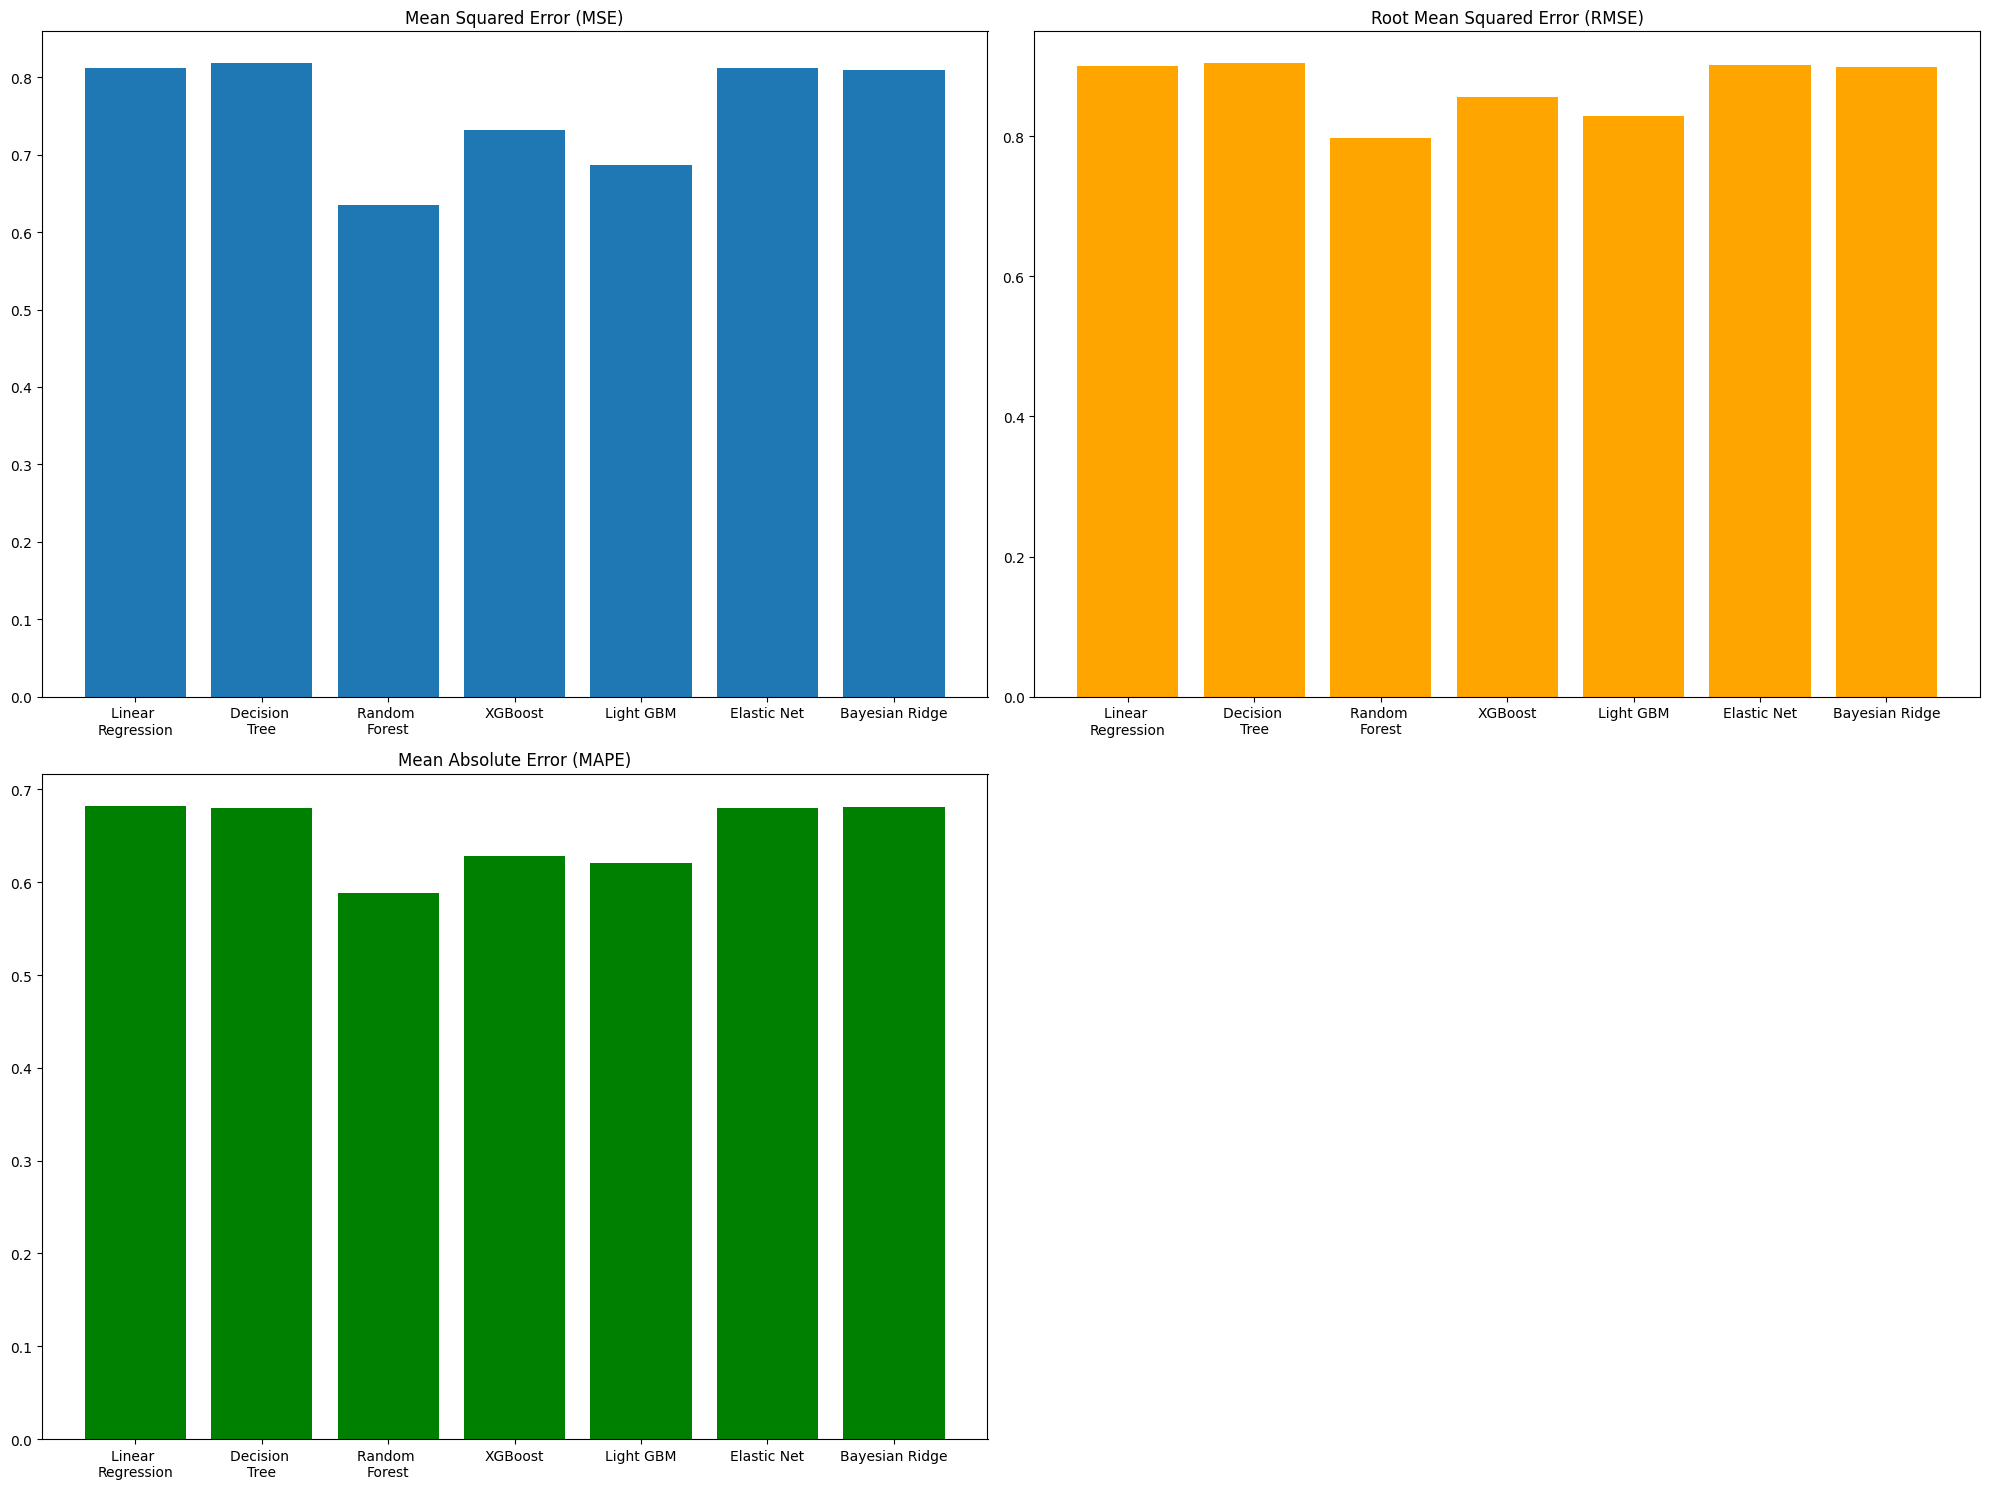

In [84]:
mse_values = [lr_mse, dt_mse, rf_mse, xg_mse, lg_mse, en_mse, bayesian_ridge_mse]
rmse_values = [lr_rmse, dt_rmse, rf_rmse, xg_rmse, lg_rmse, en_rmse, bayesian_ridge_rmse]
mae_values = [lr_mae, dt_mae, rf_mae, xg_mae, lg_mae, en_mae, bayesian_ridge_mae]
models = ['Linear \nRegression', 'Decision \nTree', 'Random \nForest', 'XGBoost', 'Light GBM', 'Elastic Net', 'Bayesian Ridge']

# Plot the metrics for each model
plt.figure(figsize=(20, 15))

# MSE plot
plt.subplot(2, 2, 1)
plt.bar(models, mse_values)
plt.title('Mean Squared Error (MSE)')

# RMSE plot
plt.subplot(2, 2, 2)
plt.bar(models, rmse_values, color='orange')
plt.title('Root Mean Squared Error (RMSE)')

# MAPE plot
plt.subplot(2, 2, 3)
plt.bar(models, mae_values, color='green')
plt.title('Mean Absolute Error (MAPE)')

plt.tight_layout()
plt.show()

# Plotting R-Squared value

Text(0.5, 1.0, 'R-squared (R2) Score')

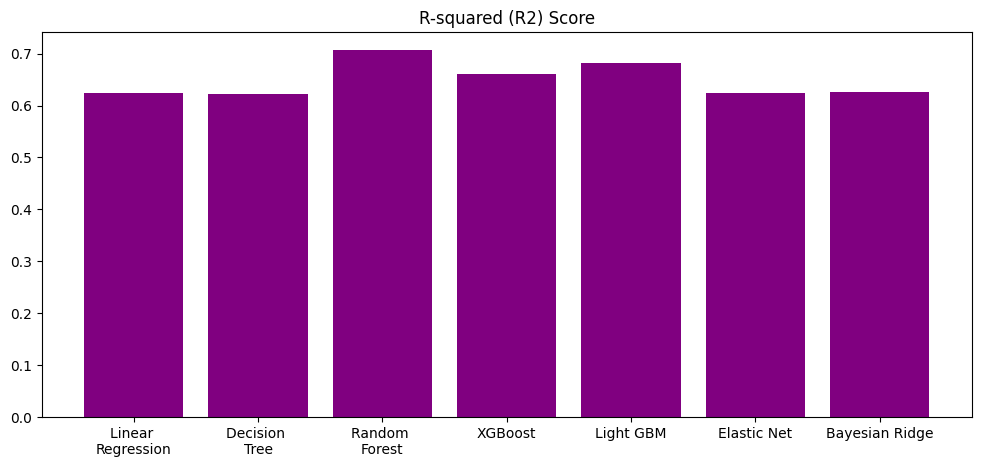

In [85]:
# R2 plot

r2_values = [lr_score, dt_score, rf_score, xg_score, lg_score, en_score, bayesian_ridge_score] 
plt.figure(figsize=(12, 5))

plt.bar(models, r2_values, color='purple')
plt.title('R-squared (R2) Score')

In [86]:
Models = ['Linear Regression', 'Decision Tree', 'Random Forest', 'XGBoost', 'Light GBM', 'Elastic Net' , 'Bayesian Ridge']

In [87]:
result_df = pd.DataFrame({
    'Model': Models,
    'R-Squared': r2_values, 
    'MSE': mse_values,
    'RMSE': rmse_values,
    'MAE': mae_values,
})

In [88]:
result_df

,Model,R-Squared,MSE,RMSE,MAE
0,Linear Regression,0.624588,0.811992,0.901106,0.682662
1,Decision Tree,0.621533,0.818600,0.904765,0.679971
2,Random Forest,0.706262,0.635337,0.797080,0.587967
3,XGBoost,0.661333,0.732515,0.855871,0.628288
4,Light GBM,0.682233,0.687309,0.829041,0.620751
5,Elastic Net,0.624401,0.812395,0.901330,0.679735
6,Bayesian Ridge,0.625906,0.809140,0.899522,0.681423


# Pickle file

In [89]:
filename = "fish_scale.sav"
pickle.dump(sc, open(filename, "wb"))
loaded_scaler = pickle.load(open("fish_scale.sav", "rb"))

In [90]:
filename = "fish_model_5.sav"
pickle.dump(rf, open(filename, "wb"))
loaded_model = pickle.load(open("fish_model_5.sav", "rb"))


# Testing for new inputs

In [91]:
original_list =[3.25, 0.828, 1.674, 0, 1, 1.452]

In [92]:
def create_one_hot_encoding(value, num_categories):
    # Initialize a list with zeros
    one_hot_encoding = [0] * num_categories

    # Set the value at the specified index to 1
    one_hot_encoding[value] = 1

    return one_hot_encoding

# Number of categories for index 4 and index 5
num_categories_index4 = 5
num_categories_index5 = 7

# Create one-hot encoding for index 4
index4_value = original_list[3]
one_hot_encoding_index4 = create_one_hot_encoding(index4_value, num_categories_index4)

# Create one-hot encoding for index 5
index5_value = original_list[4]
one_hot_encoding_index5 = create_one_hot_encoding(index5_value, num_categories_index5)

# Create a new list with one-hot encoded values
new_list = original_list[:3] + one_hot_encoding_index4 + one_hot_encoding_index5 + [original_list[5]]
print(f"New list with one-hot encoded values: {new_list}")


scaled_input = loaded_scaler.transform([new_list])

# Make predictions using the loaded model
prediction = loaded_model.predict(scaled_input)

print(prediction)

New list with one-hot encoded values: [3.25, 0.828, 1.674, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1.452]
[3.89119955]
